In [1]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange, tqdm

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    has_all_transitions,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model

import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

random.seed(0)
torch.manual_seed(0)

GPU is available


In [2]:
P, L = 100, 1

N_gain, N_p = 20, 20
max_seq_len = 10
max_gain = 0.5
max_p = 1

n_epochs = 1000000

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)

# # ReLU
# problem = lambda seq: np.sum(seq) % 2
# lr = 0.02
# nonlinearity = "relu"

# tanh
problem = lambda seq: np.sum(seq) % 2
lr = 0.03
nonlinearity = "tanh"


# Random
# automaton_problem = gen_rand_automaton(symbols, [[1, 0], [0, 1]], 7, 0.6)
# problem = lambda seq: int(np.argmax(automaton_problem.compute(seq)))
# display_automata(reduce_automaton(automaton_problem))
# plt.savefig("plots/automaton.pdf",format="pdf")
# lr = 0.02
# nonlinearity = "relu"


# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
val_seq_length = 100
val_datapoints = 30
analysis_seq_lengths = list(range(1, max_seq_len + 1))

In [3]:
def trial(gain, p):
    ## Generate data

    # Generate datasets
    training_datasets = []
    for length in range(1, max_seq_len + 1):
        n = np.random.binomial(2**length, p)
        if n == 0:
            continue
        data = seq_data(device, problem, encoding, seq_len=length, n_datapoints=n)
        training_datasets.append(data)
    validation_datasets = [
        seq_data(
            device,
            problem,
            encoding,
            n_datapoints=val_datapoints,
            seq_len=val_seq_length,
        )
    ]
    analysis_data = [
        seq_data(device, problem, encoding, seq_len=length)
        for length in analysis_seq_lengths
    ]
    tracked_datasets = validation_datasets + training_datasets

    ## Instantiate model
    model = Model(
        encoding=encoding,
        input_size=2,
        output_size=2,
        hidden_dim=P,
        n_layers=L,
        device=device,
        nonlinearity=nonlinearity,
        gain=gain,
    )

    ## Setup compiler
    criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    }

    ## Training run
    compiler.training_run(
        training_datasets,
        n_epochs=n_epochs,
        batch_size=128,
        progress_bar=True,
        conv_thresh=0.01,
    )

    ## Collect data
    loss = compiler.trackers["loss"].get_trace()
    val_loss = loss.query("Dataset==0")[0].to_numpy()[-1]
    train_loss = loss.query("Dataset>0").groupby("Epoch").mean().to_numpy()[-1]
    initial_hidden = model.init_hidden(batch_size=1)[-1]
    hidden_function = lambda inputs: model(inputs)[1][-1]
    output_function = lambda inputs: model(inputs)[0]
    automaton = to_automaton(
        hidden_function,
        output_function,
        initial_hidden,
        analysis_data,
        encoding,
        merge_distance_frac=0.1,
    )
    n_states = len(automaton.states)
    is_finite = automaton.is_finite()
    n_exit = sum(
        not has_all_transitions(state, automaton.transition_function)
        for state in automaton.states
    )

    val_loader = torch.utils.data.DataLoader(validation_datasets[0], batch_size=128)
    correct = 0
    for x, y in val_loader:
        predictions = torch.argmax(model(x)[0], axis=1)
        targets = torch.argmax(y, axis=1)
        correct += sum(predictions == targets)
    val_acc = (correct / len(validation_datasets[0])).item()

    return train_loss, val_loss, val_acc, n_states, is_finite, n_exit

In [4]:
gains = np.linspace(0.1, max_gain, N_gain)
seq_lens = np.linspace(0.1, max_p, N_p)
(
    gain_data,
    seq_len_data,
    train_loss_data,
    val_loss_data,
    val_acc_data,
    n_states_data,
    is_finite_data,
    n_exit_data,
) = [[] for _ in range(8)]

for gain in gains:
    print(gain)
    for seq_len in seq_lens:

        train_loss, val_loss, val_acc, n_states, is_finite, n_exit = trial(
            gain, seq_len
        )
        for data, item in zip(
            (
                gain_data,
                seq_len_data,
                train_loss_data,
                val_loss_data,
                val_acc_data,
                n_states_data,
                is_finite_data,
                n_exit_data,
            ),
            (gain, seq_len, train_loss, val_loss, val_acc, n_states, is_finite, n_exit),
        ):
            data.append(item)

0.1


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


0.12105263157894737


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


0.14210526315789473


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


0.1631578947368421


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


0.1842105263157895


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


0.20526315789473684


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


0.22631578947368422


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


0.24736842105263157


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


0.26842105263157895


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


0.2894736842105263


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


0.31052631578947365


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


0.3315789473684211


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


0.3526315789473684


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


0.37368421052631584


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


0.39473684210526316


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


0.4157894736842105


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


0.4368421052631579


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


0.45789473684210524


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


0.4789473684210527


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


0.5


Computing automata: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


In [5]:
for data, name in zip(
    (
        gain_data,
        seq_len_data,
        train_loss_data,
        val_loss_data,
        val_acc_data,
        n_states_data,
        is_finite_data,
        n_exit_data,
    ),
    (
        "gain",
        "seq_len",
        "train_loss",
        "val_loss",
        "val_acc",
        "n_states",
        "is_finite",
        "n_exit",
    ),
):
    np.save("plots/" + name, data)

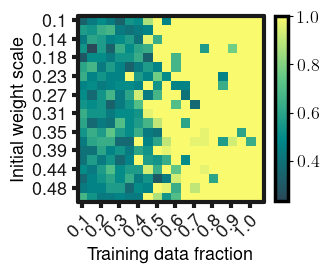

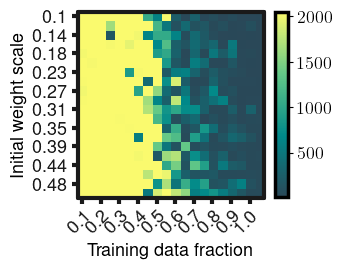

In [ ]:
# n_states_total = np.array([sum(2**i for i in range(len + 1)) for len in seq_len_data])
# n_states_norm = n_states_data / n_states_total
N_len = N_p

## Plot results
publication.set_color_gradient(2)

x_labels = np.around(seq_lens, 1)
y_labels = np.around(gains, 1)

x_labels = [l if n % 2 == 0 else None for n, l in enumerate(x_labels)]
y_labels = [l if n % 2 == 0 else None for n, l in enumerate(y_labels)]

# C = 8000
# G_phase_trans = (N / C) ** 1 * (gains / G)

val_acc_grid = np.array(val_acc_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(3, 3))
# plt.plot(
#     (N_len + 1) * seq_lens - 2,
#     (N_gain + 1) * G_phase_trans - 2,
#     linestyle="--",
#     color="r",
# )
plt.imshow(val_acc_grid)
plt.xlabel("Training data fraction")
plt.ylabel("Initial weight scale")
publication.im_show(
    colorbar=True,
    x_labels=x_labels,
    y_labels=y_labels,
    save_path="plots/val_acc_grid",
)
plt.show()

n_states_grid = np.array(n_states_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(3, 3))
# plt.plot(
#     (N_len + 1) * seq_lens - 2,
#     (N_gain + 1) * G_phase_trans - 2,
#     linestyle="--",
#     color="r",
# )
plt.imshow(n_states_grid)
plt.xlabel("Training data fraction")
plt.ylabel("Initial weight scale")
publication.im_show(
    colorbar=True,
    x_labels=x_labels,
    y_labels=y_labels,
    save_path="plots/n_states_grid",
)
plt.show()

In [7]:
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]

G = []
for gain in gains:
    model = Model(
        encoding=encoding,
        input_size=2,
        output_size=2,
        hidden_dim=P,
        n_layers=L,
        device=device,
        nonlinearity=nonlinearity,
        gain=gain,
    )

    H = []
    X = []
    for dataset in analysis_data:
        for x, y in torch.utils.data.DataLoader(dataset, batch_size=128):
            h = model(x)[1][0, :, :]
            H.append(h)

    H = torch.concatenate(H)
    H = H.detach().cpu().numpy()
    G.append(np.std(H))

G = np.array(G)
N = seq_lens * np.sum(2**n for n in range(1, max_seq_len + 1))

/tmp/ipykernel_27582/2584335581.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = seq_lens * np.sum(2**n for n in range(1, max_seq_len + 1))


In [8]:
(
    gain_data,
    seq_len_data,
    train_loss_data,
    val_loss_data,
    val_acc_data,
    n_states_data,
    is_finite_data,
    n_exit_data,
) = [
    np.load(f"plots/{name}.npy")
    for name in (
        "gain",
        "seq_len",
        "train_loss",
        "val_loss",
        "val_acc",
        "n_states",
        "is_finite",
        "n_exit",
    )
]